# Performance Tests of Matrix Multiply Algorithms

The point of this notebook is to test different matrix-multiply algorithms for doing the vis-cpu algorithm's $V = ZZ^\dagger$. In this notebook, we don't care about _how_ we got $Z$, only that it is complex-valued, and its shape is supposed to be $N_{\rm feed} N_{\rm ant} \times N_{\rm ax} N_{\rm src}$, which is generally _very_ non-square. 

We define a number of methods that compute $V$, and test their performance on different shapes of $Z$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import methods
import yaml
from getperf import TimeResult

In [5]:
cache: str = "/ocean/projects/phy210034p/sgm/visgpu-mm-profiling/cache"

In [6]:
cache = Path(cache)

In [7]:
def get_all_timings(cache: Path, precision: str, kind: str):
    timings = sorted(cache.glob(f"*_{precision}_{kind}.yaml"))

    nsides = set()
    nants = set()
    redfracs = set()

    normal = {}
    redund = {}

    for fl in timings:
        method, size, _, _ = fl.stem.split("_")
        n1, nside = size.split('x')
        
        nside = int(nside)
        nsides.add(nside)
        cls = getattr(methods, method)

        
        with open(fl, 'r') as yml:
            d = yaml.safe_load(yml)


        if not cls.is_redundant:
            nant = int(n1)
            nants.add(nant)
            if method not in normal:
                normal[method] = {}

            normal[method][(nant, nside)] = TimeResult(**d)
        else:
            redfrac = int(n1)
            redfracs.add(redfrac)
            if method not in redund:
                redund[method] = {}
            redund[method][(redfrac, nside)] = TimeResult(**d)
    
    return normal, redund, sorted(nsides), sorted(nants), sorted(redfracs)

In [13]:
normal_single_row, redundant_single_row, nsides, nants, redfracs = get_all_timings(cache, 'single', 'row')
normal_double_row, redundant_double_row, _, _, _ = get_all_timings(cache, 'double', 'row')
normal_single_col, redundant_single_col, _, _, _ = get_all_timings(cache, 'single', 'col')
normal_double_col, redundant_double_col, _, _, _ = get_all_timings(cache, 'double', 'col')

print("Full Dot Product (single row): ", len(normal_single_row))
print("Full Dot Product (double row): ", len(normal_double_row))
print("Full Dot Product (single col): ", len(normal_single_col))
print("Full Dot Product (double col): ", len(normal_double_col))

print("Redundant (single row): ", len(redundant_single_row))
print("Redundant (double row): ", len(redundant_double_row))
print("Redundant (single col): ", len(redundant_single_col))
print("Redundant (double col): ", len(redundant_double_col))


Full Dot Product (single row):  5
Full Dot Product (double row):  5
Full Dot Product (single col):  0
Full Dot Product (double col):  0
Redundant (single row):  3
Redundant (double row):  3
Redundant (single col):  0
Redundant (double col):  0


In [14]:
nsrcs = [2 * 12*nside**2 for nside in nsides]

## Plotting Functions

In [10]:
def plot_timings(timings: dict[str, dict[tuple[int, int], "TimeResult"]]):
    fig, ax = plt.subplots(2, max(len(nants), len(nsrcs)), figsize=(15, 8), constrained_layout=True, sharex='row', sharey='row')

    for i, (nside, nsrc) in enumerate(zip(nsides, nsrcs)):
        for j, (method, results) in enumerate(timings.items()):

            res = [results.get((n, nside), None) for n in nants]
            ax[0, i].plot(nants, [r.best if r is not None else np.nan for r in res], color=f'C{j}', label=method)

        ax[0, i].set_title(f"Nside={nside}")
        ax[0, i].set_xlabel("Nants x Nfeeds")
        ax[0, 0].set_ylabel("Time [sec]")
#        ax[0, i].plot(nants, np.array(nants) * (results[(np.max(nants), nside)].best/np.max(nants)), ls='--', color='k')
        
        ax[0, i].set_xscale('log')
        ax[0, i].set_yscale('log')
    
    for j in range(i+1, ax.shape[1]):
        ax[0, j].axis('off')
        
        
    for i, nant in enumerate(nants):
        for j, (method, results) in enumerate(timings.items()):
            res = [results.get((nant, n), None) for n in nsides]

            ax[1, i].plot(nsrcs, [r.best if r is not None else np.nan for r in res], color=f'C{j}')

        ax[1,i].set_title(f"Nant x Nfeed={nant}")
        ax[1,i].set_xlabel("nsrc")
        ax[1, i].set_xscale('log')
        ax[1, i].set_yscale('log')
 #       ax[1, i].plot(nsrcs, np.array(nsrcs) * (results[(nant, np.max(nsides))].best/np.max(nsrcs)), ls='--', color='k')
    
    ax[0,0].legend(frameon=False, ncols=2)
    return fig, ax

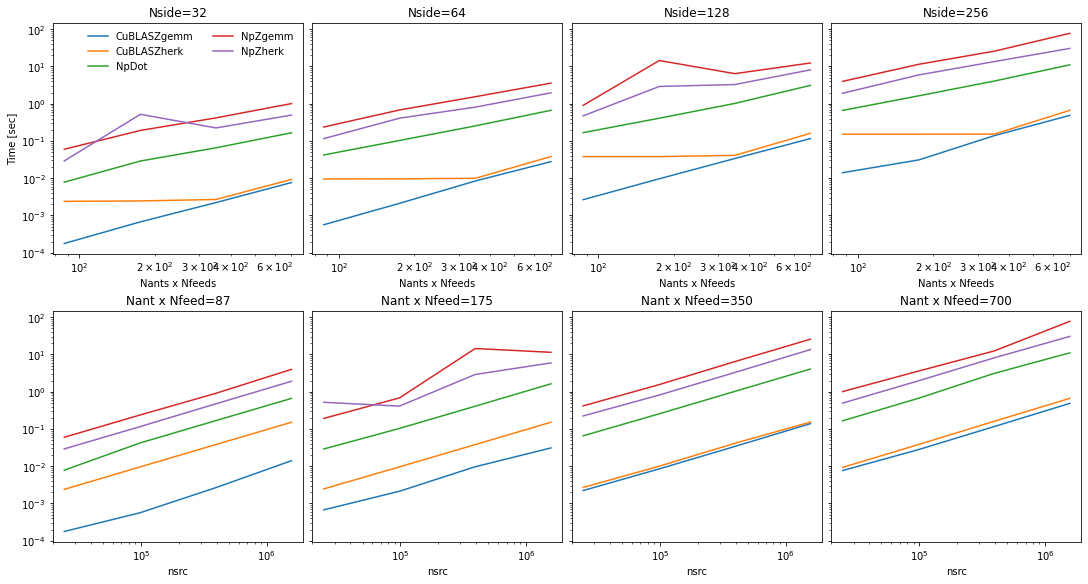

In [16]:
plot_timings(normal_single_row);

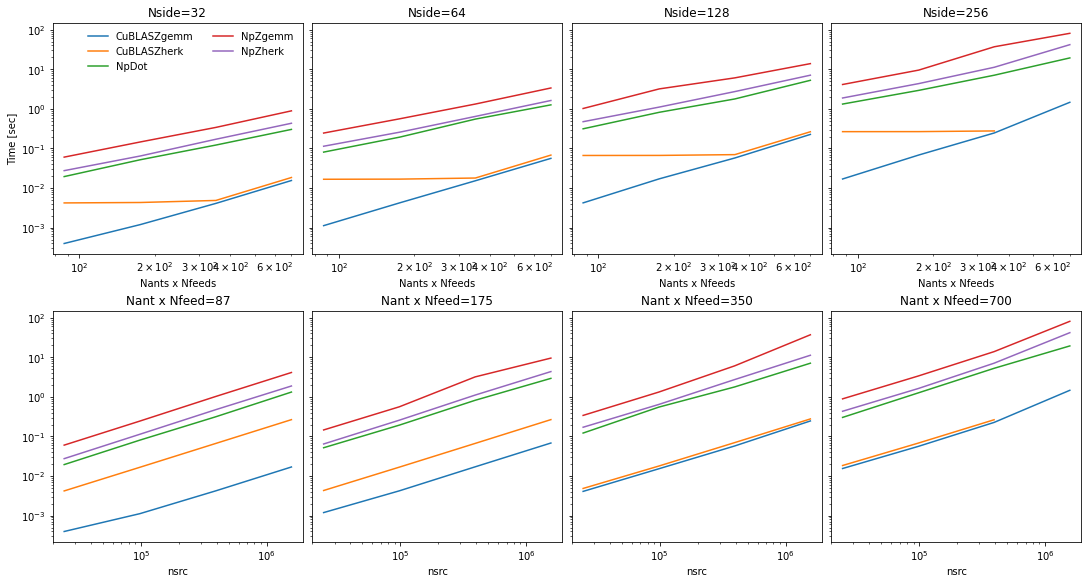

In [17]:
plot_timings(normal_double_row);

In [18]:
def plot_timings_reds(red_timings: dict[str, dict[tuple[int, int], TimeResult]], 
                      timings: dict[str, dict[tuple[int, int], TimeResult]]):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout=True)

    nants_redundant = np.max(nants)

    for j, (method, results) in enumerate(timings.items()):
        res = [results.get((nants_redundant, n), None) for n in nsides]
        ax.plot(nsrcs, [r.best if r is not None else np.nan for r in res], color=f'C{j}', label=method)
        
    for j, (method, results) in enumerate(red_timings.items(), start=len(timings)):
        for k, frac in enumerate(redfracs):
            res = [results.get((frac, n), None) for n in nsides]
            ax.plot(
                nsrcs, [r.best if r is not None else np.nan for r in res], 
                color=f'C{j%10}', ls=[':', '--', '-.', (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][k], 
                label=f"{method} ({frac}% red.)"
            )
        
    ax.set_title(f"Nant x Nfeed={nants_redundant}")
    ax.set_xlabel("nsrc")
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.plot(nsrcs, np.array(nsrcs) * (results[(350, np.max(nsrcs))].best/np.max(nsrcs)), ls='--', color='k')

    ax.legend(frameon=False, ncols=3)
    return fig, ax

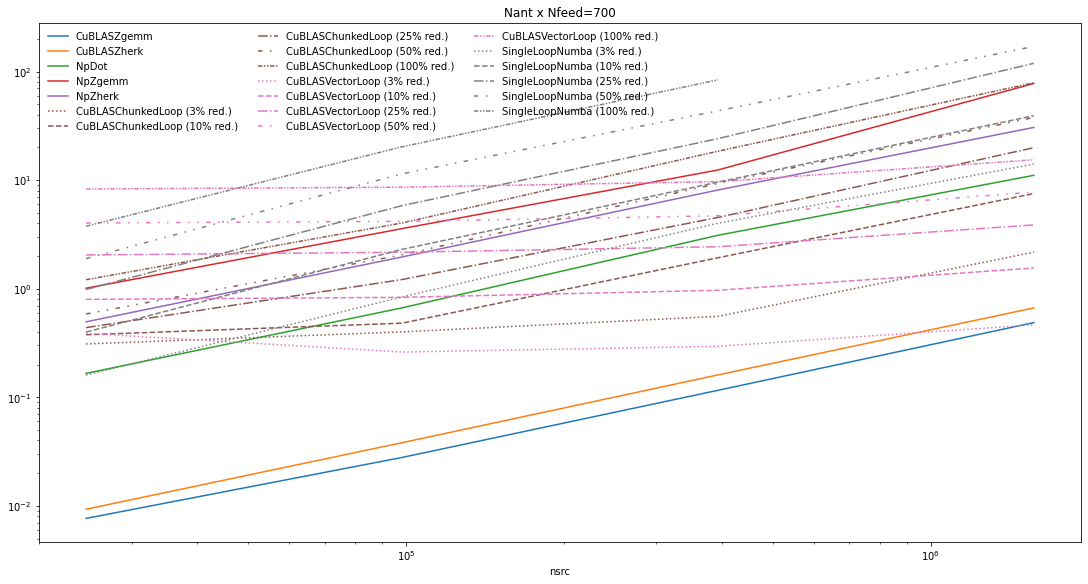

In [19]:
plot_timings_reds(redundant_single_row, normal_single_row);

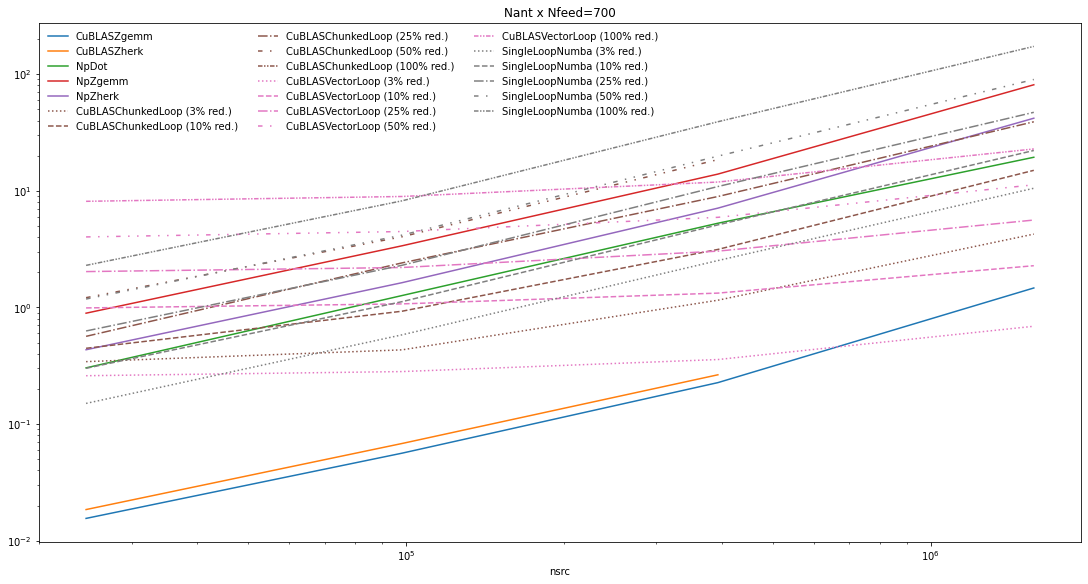

In [20]:
plot_timings_reds(redundant_double_row, normal_double_row);

In [ ]:
def plot_comparison(
    t1: dict[str, dict[tuple[int, int], TimeResult]], 
    t2: dict[str, dict[tuple[int, int], TimeResult]],
    nant: int
):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout=True)

    nants_redundant = np.max(nants)

    # def get_res(t, method):
    #     res = [t[method].get((nants_redundant, n), None) for n in nsides]
    #     return np.array([r.best if r is not None else np.nan for r in res])

    # for j, method in enumerate(t1):
    #     r1 = get_res(t1, method)
    #     r2 = get_res(t2, method)
        
    #     ax.plot(nsrcs, r1 / r2, color=f'C{j}', label=method)

    def get_res_redt, method):
        res = [t[method].get((nants_redundant, n), None) for n in nsides]
        return np.array([r.best if r is not None else np.nan for r in res])

    for j, (method, results) in enumerate(red_timings.items(), start=len(timings)):
        for k, frac in enumerate(redfracs):
            res = [results.get((frac, n), None) for n in nsides]
            ax.plot(
                nsrcs, [r.best if r is not None else np.nan for r in res], 
                color=f'C{j%10}', ls=[':', '--', '-.', (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][k], 
                label=f"{method} ({frac}% red.)"
            )
        
    ax.set_title(f"Nant x Nfeed={nants_redundant}")
    ax.set_xlabel("nsrc")
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.plot(nsrcs, np.array(nsrcs) * (results[(350, np.max(nsrcs))].best/np.max(nsrcs)), ls='--', color='k')

    ax.legend(frameon=False, ncols=3)
    return fig, ax